In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import iris


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Define variables and set up environment

In [26]:
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from PDF_plotting_functions import *
# sys.path.insert(0, root_fp + 'Scripts/Regridding')
# from Regridding_functions import *
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_geometry_functions import *

# Define ensemble member numbers
ems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']
# Define time period
timeperiod = 'Baseline'
# define whether to trim to JJA
jja_status = 'jja'

### Choose the spatial datafiles needed

In [27]:
# Create region with Leeds at the centre
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:27700'})
# Create otuline of Leeds itself
leeds_gdf = create_leeds_outline({'init' :'epsg:27700'})

################################################################
### Load in model times, and define which times are within the period which overlaps between model and observations (1990-01-01 00:00:00 and 2000-11-30 23:00:00 )

This is tricky to do as the model date uses a 360 day calendar, with each month having 30 days.  
Consequently, February has 30 days and these dates cannot be recognised by the Datetime function and so it is not possible to trim the data using datetime dates.  
Instead, find the index positions of the dates which are within this time period and assign these a value of '0' in the array  
This array is then stacked on top of itself 1221 times (this is how many cells there are in the leeds-at-centre array).  
This creates an array of the same length as the leeds-at-centre.npy array which contains the precip values.  
These two arrays can then be joined as a dataframe, and all those rows with a '0' in the date column are then deleted to leave only the precip values within the overlapping time period 

In [28]:
# Load in timestamps that relate to one cell's worth of data
model_times_12km = pd.read_csv("ProcessedData/TimeSeries/UKCP18/12km/Baseline/leeds-at-centre/timestamps_jjaflag.csv").copy()
model_times_2_2km = pd.read_csv("ProcessedData/TimeSeries/UKCP18/2.2km/Baseline/leeds-at-centre/timestamps_jjaflag.csv")
model_times_2_2km_regridded = pd.read_csv("ProcessedData/TimeSeries/UKCP18/2.2km_regridded_12km/Baseline/leeds-at-centre/timestamps_jjaflag.csv")

#################################################################
### Loop through ensemble members and load in data for whole of leeds and trim to contain only data from the overlapping time period, and the results do dictionaries
################################################################

In [ ]:
# Set value as NA for values not in required date range
# This is to do with number of hours, so for 2.2km and 2.2km regridded it is the same
model_times_2_2km_regridded.loc[0:78480,'times'] =0 
model_times_12km.loc[0:3270,'times'] =0 
model_times_2_2km.loc[0:78480,'times'] =0 

In [19]:
# # Create a dictionary to store results
leeds_data_dict = {}
leeds_data_dict_overlapping = {}

In [34]:
# Loop through ensemble members
for resolution in ['2.2km', '12km', '2.2km_regridded_12km']:
    print(resolution)
    # Repeat this 1221 times to be the same length as the precip data for whole of Leeds
    # This is to do with the number of cells (so for 12km and 2.2km_regridded_12km it is 36)
    if resolution == '2.2km':
        model_times = pd.concat([model_times_2_2km]* 1221)
        #model_times = np.tile(model_times_2_2km, 1221)
    elif resolution == '2.2km_regridded_12km':
        model_times = pd.concat([model_times_2_2km_regridded]* 36)
         #model_times = np.tile(model_times_2_2km_regridded, 36)
    elif resolution == '12km':
        model_times = pd.concat([model_times_12km]* 36)
        #model_times = np.tile(times, 36)

    for em in ems:
        print(em)

        # Load in 20 years of model data for the whole of leeds
        # Join to corresponding dates/times
        leeds_data = pd.DataFrame({"Date" : model_times['times'],
                                   'Precipitation (mm/hr)' :np.load(f"ProcessedData/TimeSeries/UKCP18/{resolution}/{timeperiod}/leeds-at-centre/{em}/leeds-at-centre.npy")
                                   ,'jja' : model_times["in_jja"]})
        # JJA?
        if jja_status == 'jja':
            leeds_data = leeds_data[leeds_data['jja'].notna()]

        # Add to dictionary
        leeds_data_dict['EM{}_{}'.format(em, resolution)] = leeds_data

        # Keep only data from overlapping times
        leeds_data_overlapping = leeds_data.loc[leeds_data['Date'] != 0]

        # Add data to dictionary
        leeds_data_dict_overlapping['EM{}_{}'.format(em, resolution)] = leeds_data_overlapping

        # delete variables to save memory
        del leeds_data, leeds_data_overlapping

2.2km
01
04
05
06
07
08
09
10
11
12
13
15
12km
01
04
05
06
07
08
09
10
11
12
13
15
2.2km_regridded_12km
01
04
05
06
07
08
09
10
11
12
13
15


### Add dictionary keys containing data for all ensemble members, and delete data from individual ensemble members

In [36]:
# Create a dataframe containing the data from across all ensemble members
for dict in [leeds_data_dict, leeds_data_dict_overlapping]:
    for resolution in ['2.2km', '12km', '2.2km_regridded_12km']:
        frames = [dict['EM01_{}'.format(resolution)], dict['EM04_{}'.format(resolution)], dict['EM05_{}'.format(resolution)], dict['EM06_{}'.format(resolution)],
                  dict['EM07_{}'.format(resolution)], dict['EM08_{}'.format(resolution)], dict['EM09_{}'.format(resolution)], dict['EM10_{}'.format(resolution)]
                  , dict['EM11_{}'.format(resolution)], dict['EM12_{}'.format(resolution)], dict['EM13_{}'.format(resolution)], dict['EM15_{}'.format(resolution)]]

        # Add the concat of all these frames to the dictionary
        dict['Model {}'.format(resolution)] = pd.concat(frames)

        # Delete the individual ensemble member dataframes
        keys_to_remove =("EM01_{}".format(resolution), "EM04_{}".format(resolution), "EM05_{}".format(resolution), "EM06_{}".format(resolution), "EM07_{}".format(resolution), "EM08_{}".format(resolution),
                     "EM09_{}".format(resolution), "EM10_{}".format(resolution), "EM11_{}".format(resolution), "EM12_{}".format(resolution), "EM13_{}".format(resolution), "EM15_{}".format(resolution))
        for key in keys_to_remove:
            if key in dict:
                del dict[key]

################################################################
################################################################
### Add both native and regridded observations data to dictionary
################################################################
################################################################

In [37]:
################################################################
################################################################
####### Add both native and regridded observations data to dictionary
################################################################
################################################################
print("Making dicts")
# 1km -- Repeat times 6083 times to be the same length as the precip data for whole of Leeds  (73 cells x 83 cells)
leeds_data_dict['Observations'] =  pd.DataFrame({"Date" :  pd.concat([pd.read_csv("ProcessedData/TimeSeries/CEH-GEAR/1km/leeds-at-centre/timestamps_jjaflag.csv")]*6059)['times'],
                                       "Precipitation (mm/hr)" : np.load("ProcessedData/TimeSeries/CEH-GEAR/1km/leeds-at-centre/leeds-at-centre.npy"),
                                        'jja': pd.concat([pd.read_csv("ProcessedData/TimeSeries/CEH-GEAR/1km/leeds-at-centre/timestamps_jjaflag.csv")]*6059)['in_jja']})


# 2.2km --- Repeat time data 1221 times to be the same length as the precip data for whole of Leeds
leeds_data_dict['Observations Regridded_2.2km'] =  pd.DataFrame({"Date" :  pd.concat([pd.read_csv("ProcessedData/TimeSeries/CEH-GEAR/2.2km/NearestNeighbour/leeds-at-centre/timestamps_jjaflag.csv")]*1221)['times'],
                                       "Precipitation (mm/hr)" : np.load("ProcessedData/TimeSeries/CEH-GEAR/2.2km/NearestNeighbour/leeds-at-centre/leeds-at-centre.npy"),
                                        'jja': pd.concat([pd.read_csv("ProcessedData/TimeSeries/CEH-GEAR/2.2km/NearestNeighbour/leeds-at-centre/timestamps_jjaflag.csv")]*1221)['in_jja']})

# 12km --- Repeat time data 1221 times to be the same length as the precip data for whole of Leeds
leeds_data_dict['Observations Regridded_12km'] =  pd.DataFrame({"Date" :  pd.concat([pd.read_csv("ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/leeds-at-centre/timestamps_jjaflag.csv")]*36)['times'],
                                       "Precipitation (mm/hr)" : np.load("ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/leeds-at-centre/leeds-at-centre.npy"),
                                        'jja': pd.concat([pd.read_csv("ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/leeds-at-centre/timestamps_jjaflag.csv")]*36)['in_jja']})

Making dicts


In [62]:
####### Cut to overlapping period
leeds_data_dict_overlapping['Observations'] =  leeds_data_dict['Observations'][(leeds_data_dict['Observations']['Date'] >= '1990-01-01 00:00:00')
                                                & (leeds_data_dict['Observations']['Date']<= '2000-11-30 23:00:00 ')]
leeds_data_dict_overlapping['Observations Regridded_12km'] = leeds_data_dict['Observations Regridded_12km'][(leeds_data_dict['Observations Regridded_12km']['Date'] >= '1990-01-01 00:00:00')
                                                & (leeds_data_dict['Observations Regridded_12km']['Date'] <= '2000-11-30 23:00:00 ')]
leeds_data_dict_overlapping['Observations Regridded_2.2km'] =  leeds_data_dict['Observations Regridded_2.2km'][(leeds_data_dict['Observations Regridded_2.2km']['Date'] >= '1990-01-01 00:00:00')
                                                & (leeds_data_dict['Observations Regridded_2.2km']['Date'] <= '2000-11-30 23:00:00 ')]

################################################################
################################################################
### Trim to JJA
################################################################
################################################################

In [63]:
# Model data is already only including JJA data

In [50]:
### Trim to JJA
if jja_status == 'jja':
#     for dict in [leeds_data_dict, leeds_data_dict_overlapping]:
    for dict in [leeds_data_dict]:        
        print(dict.keys())
        for resolution in ['Observations','Observations Regridded_12km','Observations Regridded_2.2km' ]:
            print(resolution, len(dict[resolution]))
            # Extract df
            leeds_data =  dict[resolution]
            # Trim using JJA flag
            leeds_data = leeds_data[leeds_data['jja'].notna()]
            # Read to dictionary
            dict[resolution] = leeds_data

dict_keys(['Model 2.2km', 'Model 12km', 'Model 2.2km_regridded_12km', 'Observations', 'Observations Regridded_2.2km', 'Observations Regridded_12km'])
Observations 334456800
Observations Regridded_12km 1987200
Observations Regridded_2.2km 67399200


##############################################################################
##############################################################################
# Plotting
##############################################################################
##############################################################################

In [51]:
x_axis = 'linear'
y_axis = 'log'
bin_nos = 60 #(10 gives 12, 30 gives 29, 45 gives 41 bins)
xlim = 250
bins_if_log_spaced= bin_nos

### All resolutions
#############################################################

In [67]:
leeds_data_dict_overlapping['Model 2.2km'].to_csv(f"ProcessedData/TimeSeries/UKCP18/2.2km/Baseline/AllEms_jja.csv")
leeds_data_dict_overlapping['Model 12km'].to_csv(f"ProcessedData/TimeSeries/UKCP18/12km/Baseline/AllEms_jja.csv")
leeds_data_dict_overlapping['Model 2.2km_regridded_12km'].to_csv(f"ProcessedData/TimeSeries/UKCP18/2.2km_regridded_12km/Baseline/AllEms_jja.csv")

dict_keys(['Model 2.2km', 'Model 12km', 'Model 2.2km_regridded_12km', 'Observations', 'Observations Regridded_2.2km', 'Observations Regridded_12km']) 
Model 2.2km
Model 12km
Model 2.2km_regridded_12km
Observations
Observations Regridded_2.2km
Observations Regridded_12km
dict_keys(['Model 2.2km', 'Model 12km', 'Model 2.2km_regridded_12km', 'Observations', 'Observations Regridded_12km', 'Observations Regridded_2.2km']) _Overlapping
Model 2.2km
Model 12km
Model 2.2km_regridded_12km
Observations
Observations Regridded_12km
Observations Regridded_2.2km


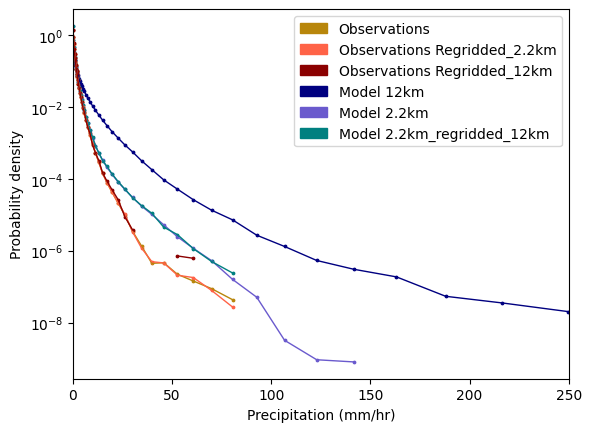

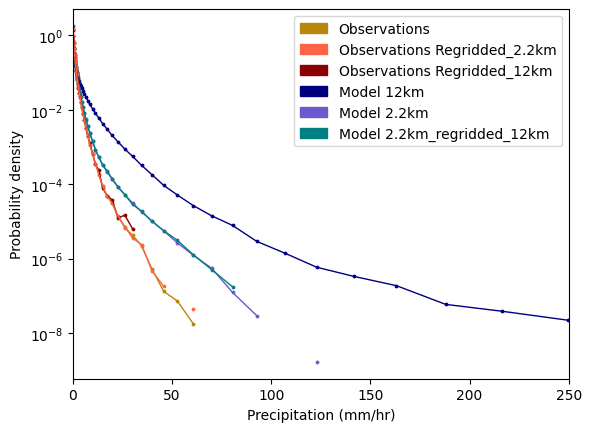

In [65]:
for dict, overlapping_status in zip([leeds_data_dict, leeds_data_dict_overlapping], ["","_Overlapping"]):
    print(dict.keys(), overlapping_status)
    cols_dict = {'Observations' : 'darkgoldenrod',
                  'Observations Regridded_2.2km' : 'tomato',
                  'Observations Regridded_12km' : 'darkred',
                  'Model 12km' : 'navy',
                  'Model 2.2km' : 'slateblue',
                  'Model 2.2km_regridded_12km': 'teal'}
    # Create patches
    patches= []
    for key, val in cols_dict.items():
        patch = mpatches.Patch(color= val, label= key)
        patches.append(patch)
    
    # Create plot
    log_discrete_histogram_lesslegend(dict, cols_dict, bin_nos, "Precipitation (mm/hr)",
                                      patches, True, xlim, x_axis, y_axis)
    #Save
#     plt.savefig("Scripts/UKCP18/PrecipitationPDFs/leeds-at-centre/Figs/RCMvsCPMvsObs/All{}_{}.png".format(overlapping_status, jja_status))